# Modelling the future resident population

AIM: extrapolate from the past data, the future resident population in Italy by age distribution, till year 2100.

I don't have a clear picture of the model yet, but I simple one could look like this:

$ p(a=0,y) = br(y) = bp_{18:45}(y) * p(a=18:43,y) $

$ p(a,y) = p(a-1,y-1) * sr(a, y-1)$

$ p(a=100+, y) = p(a=99,y-1) * sr(a, y-1) + p(a=100,y-1) * sr_{100+}(a, y-1) $

Where:
- $p(a, y)$ is the resident population of age $a$ in year $y$
- $br(y)$ is the annual new births in year $y-1$
- $bp_{18:45}(y)$ is the  "birth propagation" i.e., the fraction of people in their 18-45 years old group that will have children that year. This can be related to the fertility rate.
- $sr(a, y)$ is the annual survival rate in year $y$ (which could also be positive in case of incoming migrants) for people aged $a$ in year $y$
- $sr_{100+}(a, y)$ is the annual survival rate for the 100+ aged group

I will need to make some assumptions:
1. no significant new migrations
2. $sr$ follows a linear trend w.r.t. the years (e.g., improve in care and technology), overlooking heat waves and covid that should be just weighed in the linear regression
3. for $br$ I need to explore the previous trend and make some extrapolation, likely linear, and later try to use the $bp_{18:45}bp_{18:45}$ approach

As soon as I see limits in these assumptions I will try to improve the complexity of the model as ideas in the "Follow-up" section at the end: we need to start with a lean model to have a full pipeline.

In [1]:
from istatapi import discovery, retrieval
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Remake table: index-Age, column-Year of Observation, value-population
ds = discovery.DataSet(dataflow_identifier="DCIS_RICPOPRES2011")
ds.set_filters(tipo_dato="JAN", itter107 ="IT", stacivx="99", sesso="9")
df = retrieval.get_data(ds)

ds = discovery.DataSet(dataflow_identifier="DCIS_POPRES1")
ds.set_filters(itter107 ="IT", stacivx="99", sesso="9")
df1 = retrieval.get_data(ds)

df1["CITTADINANZA"] = 'TOTAL'
dfplot = pd.concat([
    df[["TIME_PERIOD", "CLASSE_ETA", "OBS_VALUE", "CITTADINANZA"]], 
    df1[df1.TIME_PERIOD>pd.to_datetime('2019-01-01')].rename(columns={'ETA':'CLASSE_ETA'})[["TIME_PERIOD", "CLASSE_ETA", "OBS_VALUE", "CITTADINANZA"]]
])

dfplot = (
    dfplot
    .replace("Y_GE100", "Y100")
    .query("CITTADINANZA=='TOTAL'")
    .query("CLASSE_ETA!='TOTAL'")
    .assign(eta= lambda x: x["CLASSE_ETA"].str.split("Y").str[-1].astype(int))
    .assign(year= lambda x: x["TIME_PERIOD"].dt.year)
    # aggregate eta by 5 years
    .assign(eta_group= lambda x: x["eta"] // 10 * 10)
    [["year", "eta", "OBS_VALUE"]]
    #.groupby(["TIME_PERIOD", "eta_group"]).sum()
    .sort_values(["eta", "year"])
    .reset_index()
)
dfp = dfplot[['year', 'eta', 'OBS_VALUE']].pivot(index='eta', columns='year', values='OBS_VALUE')
dfp

year    2002    2003    2004    2005    2006    2007    2008    2009    2010  \
eta                                                                            
0     523007  535656  542323  558500  551127  556884  560700  570791  562322   
1     529233  526577  538020  545596  559067  552870  560028  563021  569963   
2     528131  533126  531043  540860  548487  560347  556146  562640  564317   
3     518790  530847  537507  535545  543768  550808  563000  559193  564536   
4     515957  522484  534064  542329  540131  545782  554754  565127  560899   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
96     16400   17254   17494   20055   21122   24346   25054   27290   28086   
97     10981   11797   11980   12758   14071   15356   17559   18179   20203   
98      6838    7643    7901    8505    8725    9888   10871   12349   12977   
99      4866    4702    4971    5411    5682    5945    6643    7469    8547   
100     6121    7093    7200    8095    8538    9122    9575   10158   11297   

year    2011  ...    2014    2015    2016    2017    2018    2019    2020  \
eta           ...                                                           
0     553218  ...  512140  499940  482977  469956  455066  431007  414974   
1     561694  ...  533916  511448  499707  482975  470412  455746  436785   
2     569064  ...  540449  532895  510117  499100  482810  470813  457314   
3     565219  ...  556034  539900  531804  508569  498644  482946  471696   
4     565563  ...  565065  555647  539174  530684  507352  498240  483769   
..       ...  ...     ...     ...     ...     ...     ...     ...     ...   
96     29780  ...   19375   18513   24270   37624   38707   39836   41447   
97     21305  ...   17158   14483   13246   17960   27307   28842   29302   
98     14740  ...   15362   12386   10142    9607   12695   19650   20560   
99      9207  ...   11153   10728    8258    7145    6689    8985   13421   
100    13106  ...   17252   18420   17698   16558   14984   14132   14804   

year    2021    2022    2023  
eta                           
0     404956  400626  395348  
1     423269  407634  402454  
2     443571  425183  409723  
3     464239  444638  427219  
4     480475  464753  446724  
..       ...     ...     ...  
96     40293   40802   42623  
97     29016   29171   30356  
98     20113   20528   20999  
99     13635   13742   14528  
100    17177   19714   21872  

[101 rows x 22 columns]

In [3]:
dfpp = pd.DataFrame({col: [np.nan] * len(dfp.index) for col in dfp.columns})
for year in range(2002+1, 2022+1):
    prev_year = dfp[year-1].shift(1).to_numpy()
    dfpp[year] = (dfp[year] - prev_year)/ prev_year
dfpp = dfpp.iloc[1:-1]
dfpp = dfpp.drop(columns=[2002])
dfpp

2003      2004      2005      2006      2007      2008      2009  \
1   0.006826  0.004413  0.006035  0.001015  0.003163  0.005646  0.004139   
2   0.007356  0.008481  0.005279  0.005299  0.002290  0.005925  0.004664   
3   0.005143  0.008218  0.008478  0.005377  0.004232  0.004735  0.005479   
4   0.007120  0.006060  0.008971  0.008563  0.003704  0.007164  0.003778   
5   0.007592  0.008182  0.006784  0.009140  0.006976  0.007593  0.005785   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.245960 -0.263653 -0.233332 -0.247680 -0.231303 -0.232070 -0.231649   
96 -0.261482 -0.280408 -0.255955 -0.271404 -0.251054 -0.253212 -0.256484   
97 -0.280671 -0.305668 -0.270721 -0.298379 -0.272986 -0.278773 -0.274407   
98 -0.303980 -0.330253 -0.290067 -0.316115 -0.297278 -0.292068 -0.296714   
99 -0.312372 -0.349601 -0.315150 -0.331922 -0.318625 -0.328176 -0.312943   

        2010      2011      2012  ...      2014      2015      2016      2017  \
1  -0.001451 -0.001117 -0.002708  ... -0.000245 -0.001351 -0.000466 -0.000004   
2   0.002302 -0.001577 -0.001337  ...  0.002385 -0.001912 -0.002602 -0.001215   
3   0.003370  0.001598 -0.001633  ...  0.002810 -0.001016 -0.002047 -0.003035   
4   0.003051  0.001819  0.000717  ...  0.002745 -0.000696 -0.001345 -0.002106   
5   0.002272  0.002077  0.001547  ...  0.001975 -0.000265 -0.001139 -0.001593   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95 -0.215476 -0.209066 -0.213524  ... -0.227982 -0.218621 -0.242551 -0.223514   
96 -0.239686 -0.218188 -0.223668  ... -0.240494 -0.235916 -0.257548 -0.237470   
97 -0.259692 -0.241437 -0.234520  ... -0.270555 -0.252490 -0.284503 -0.259992   
98 -0.286154 -0.270405 -0.259986  ... -0.290078 -0.278121 -0.299731 -0.274724   
99 -0.307879 -0.290514 -0.267910  ... -0.308341 -0.301653 -0.333280 -0.295504   

        2018      2019      2020      2021      2022  2023  
1   0.000970  0.001494  0.013406  0.019989  0.006613   NaN  
2  -0.000342  0.000852  0.003441  0.015536  0.004522   NaN  
3  -0.000914  0.000282  0.001875  0.015143  0.002405   NaN  
4  -0.002393 -0.000810  0.001704  0.018612  0.001107   NaN  
5  -0.001824 -0.000461  0.001814  0.019739 -0.003728   NaN  
..       ...       ...       ...       ...       ...   ...  
95 -0.232952 -0.223105 -0.221649 -0.253108 -0.234357   NaN  
96 -0.249195 -0.237238 -0.244812 -0.275944 -0.256252   NaN  
97 -0.274213 -0.254863 -0.264434 -0.299925 -0.276028   NaN  
98 -0.293151 -0.280404 -0.287151 -0.313596 -0.292528   NaN  
99 -0.303737 -0.292241 -0.316997 -0.336819 -0.316760   NaN  

[99 rows x 21 columns]

## Birth Rate - Method #1 (DISCARDED!)
Simply extrapolate the birth rate from the past data, assuming a costant or linear trend.

In [4]:
start_year = min(dfp.columns)
end_year = 2100
historical_data = dfp.T[0].values.tolist()
historical_data += [ None for _ in range(end_year - start_year - len(historical_data)+1) ]
br_df = pd.DataFrame(historical_data, index=range(start_year, end_year+1), columns=["Historical"])
br_df.plot()

In [5]:
# Stable scenario: 
br_last = br_df.dropna().iat[-1, 0]
br_df['Predict. (Stable)'] = [ 
                              None if year<=2022 else br_last 
                              for year in range(start_year, end_year+1) 
]
br_df.plot()

In [6]:
# Following the drop from 2019
m = (br_df.at[2022,"Historical"]-br_df.at[2009,"Historical"]) / (2022-2009)
br_df['Predict. (Trend)'] = [ 
                              None if year<2009 else br_df.at[2022,"Historical"] + m*(year-2022)
                              for year in range(start_year, end_year+1) 
]
br_df.plot()

> Ooops! The number newborns are getting negative with linear extrapolation... which does not make any sense! - I'll go with the second method.

## Birth Rate - Method #2
Trying to relate the number of new borns to the 18-43 population: I keep this 25 years window because it's the one that is most likely to have children.

In [7]:
birth_propagation = dfp.loc[0]/dfp.loc[18:43+1].sum(axis=0).shift(1) # i.e., Newborns / Sum of 18-43 years old in the previous year
birth_propagation_mean = birth_propagation.mean()

fig = birth_propagation.plot()
fig.add_trace(
    go.Scatter(
        x=[2003, 2022],
        y=[birth_propagation_mean]*2,
        name="Average"
    )
)
fig.update_layout(
    yaxis_title="Birth propagation rate",
)
fig.show()


In [8]:
# Check how my birth propagation rate compares to the fertility rate
parent_window = 43-18
fertility_rate_mean = parent_window*birth_propagation_mean / 0.5 # /0.5 because the fertility rate is related to women only
fertility_rate_mean

1.220674235663214

The analysis makes sense, as it approaches the latest value from ISTAT: 1.25 in 2021 - [link](http://dati.istat.it/Index.aspx?QueryId=19029&lang=en)

It looks like a better assumption than the one of `model #1` to use a constant value for the birth propagation and compute the newborns from the 18-43 population of the previous year.

It's quite optimisting in term of population growth because I assume there will be a reverse to the mean in terms of fertility rate insted following the steep decline of the last 10 years.

NOTE: I'm not considering an extension in the fertility age >43, which is quite likely in the next decades. This should not be too much of a problem because it will mainly shift the pregnancy age and be not very impactful on the birth propagation (unless giving possibility to older women to get pregnant will significantly increase their willingness to have children).

In [9]:
# Smootly go from the 2022 birth propagation to the mean, to avoid bumps
years = range(2023, 2100+1)
last = 0.023 # following visually the trajectory of birth_propagation.iloc[-1]
diff = birth_propagation_mean - last
birth_propagation_by_year = pd.Series(
    index=years,
    data=[last + x * diff/10 for x in range(10)] + [birth_propagation_mean] * (len(years)-10)
)
birth_propagation_by_year

2023    0.023000
2024    0.023141
2025    0.023283
2026    0.023424
2027    0.023565
          ...   
2096    0.024413
2097    0.024413
2098    0.024413
2099    0.024413
2100    0.024413
Length: 78, dtype: float64

## Survival Rate
I'm now monitoring and extrapolating the change of population getting one year older, and that I generally call "survival rate" `sr`.

- The more the `sr` is negative, the higher the probability to die in that year
- `sr` can be positive if there are incoming migrants
- I want to extrapolate linear trends: from Notebook #3 I expect the `sr` to increase in modern times
- Note that the `sr` is neglecting the distribution in population, i.e., the "moving wave" of Baby Boomers we saw in Notebook #1

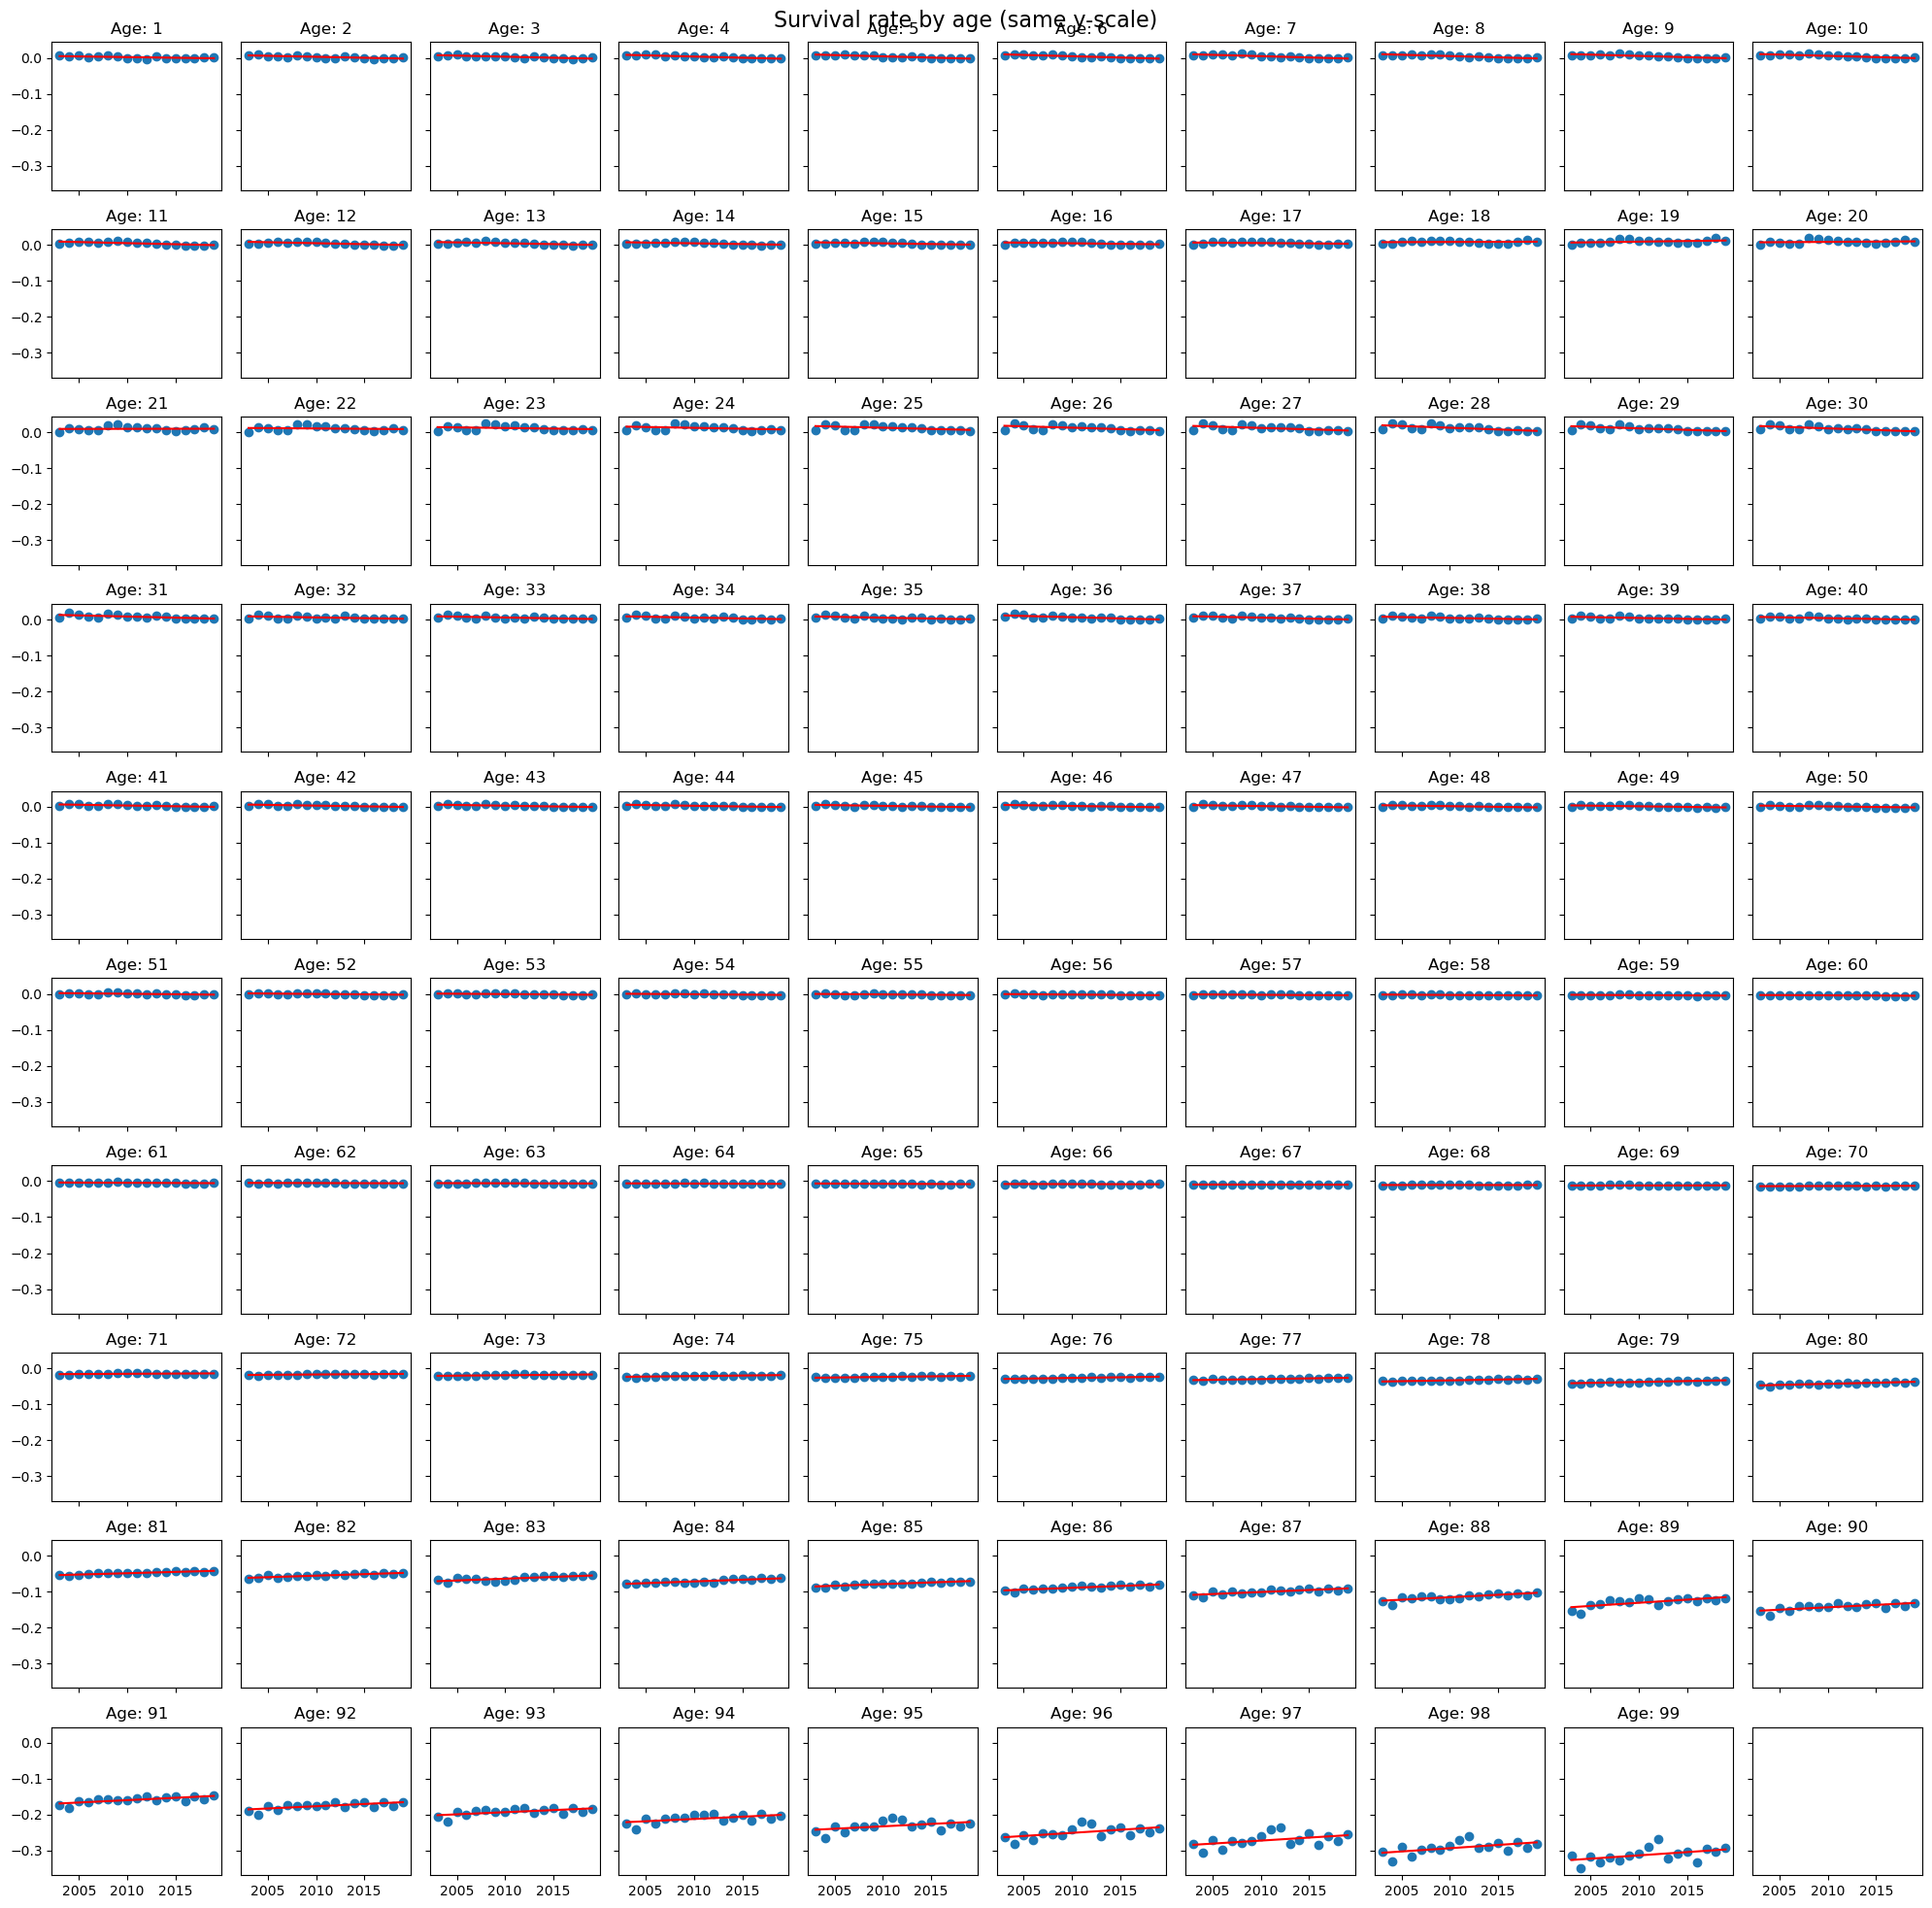

In [10]:
# Excluding the COVID-19 years and fitting a linear trend
dfsr = dfpp[list(range(2003, 2020))]
# fit a linear trend for every age group: linear regression of the survival rate from 1 to 99 (lr_sr_1_99)
lr_sr_1_99 = dfsr.apply(lambda x: np.polyfit(x.index, x, 1), axis=1)
# Plot coefficients for every age group and the linear trend
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharey=True, sharex=True)
for i, age in enumerate(dfsr.index):
    ax = axs.flatten()[i]
    ax.scatter(dfsr.columns, dfsr.loc[age].values, label=age)
    ax.set_title(f"Age: {age}")
    ax.plot(dfsr.columns, np.polyval(lr_sr_1_99.loc[age], dfsr.columns), color="red")
fig.suptitle("Survival rate by age (same y-scale)", fontsize=16)
plt.tight_layout()
plt.show()

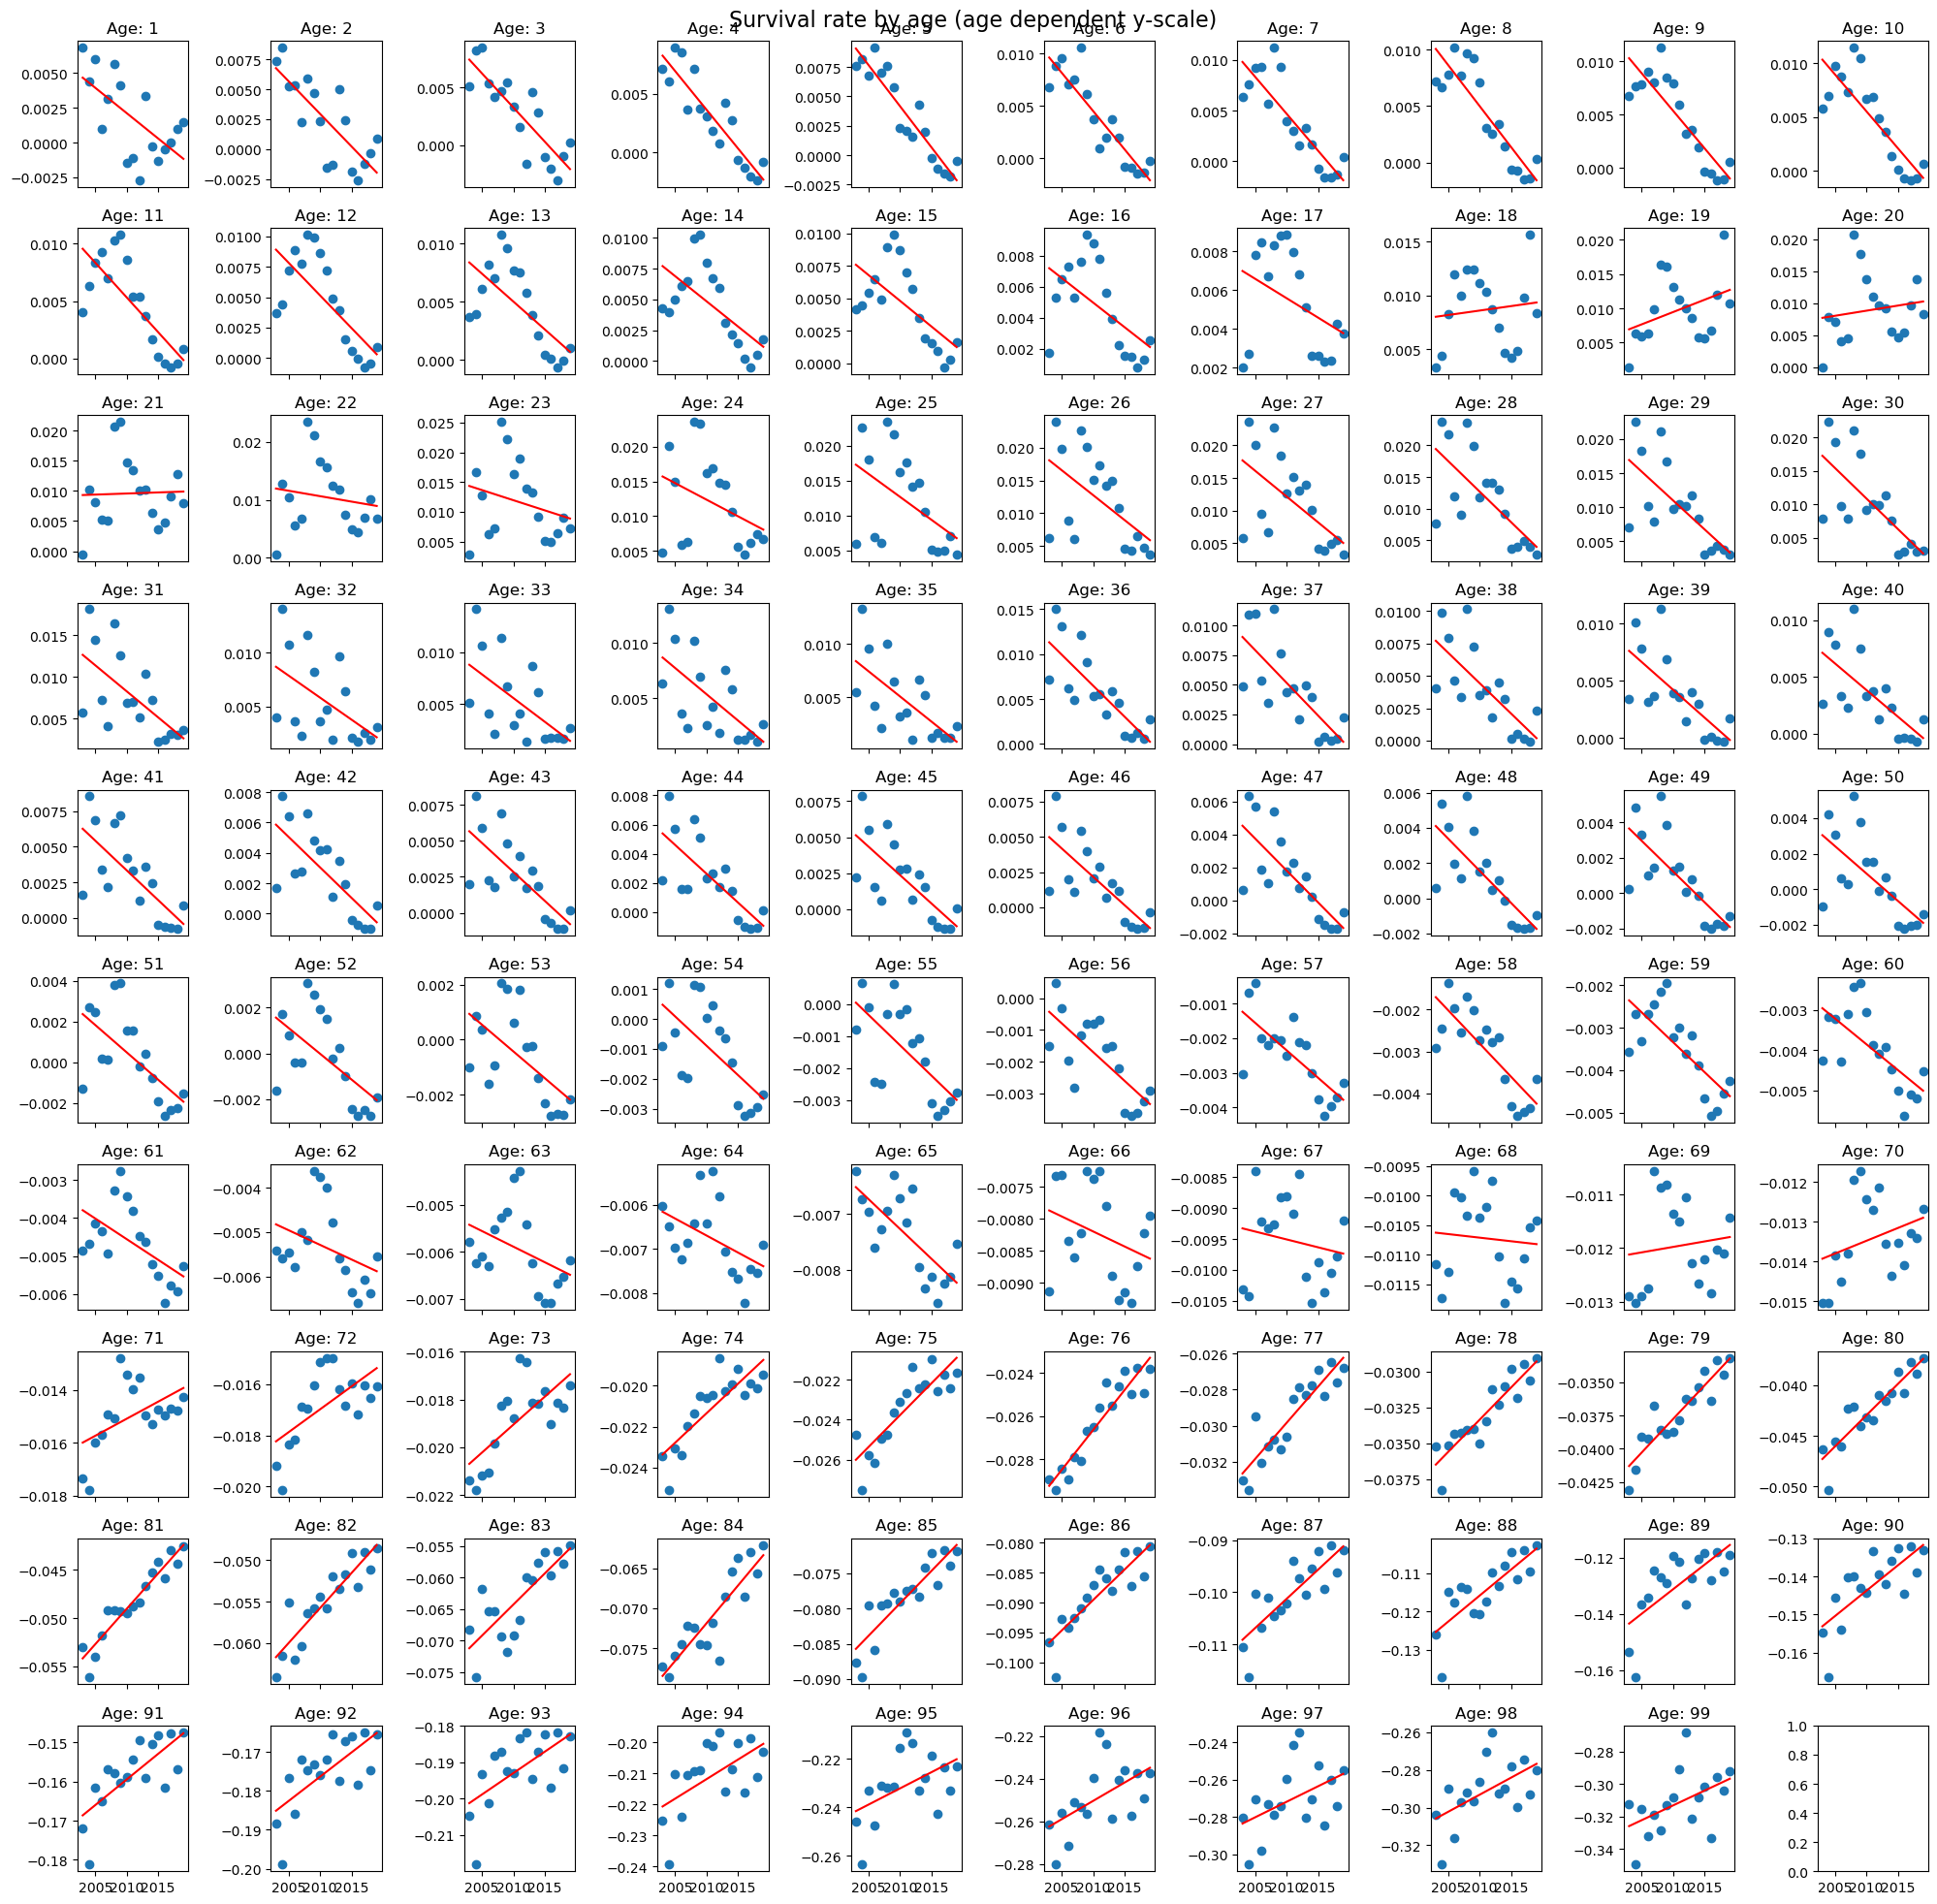

In [11]:
# Redo exactly the same thing but without sharing the y axis for better visualize the trend
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharey=False, sharex=True)
for i, age in enumerate(dfsr.index):
    ax = axs.flatten()[i]
    ax.scatter(dfsr.columns, dfsr.loc[age].values, label=age)
    ax.set_title(f"Age: {age}")
    ax.plot(dfsr.columns, np.polyval(lr_sr_1_99.loc[age], dfsr.columns), color="red")
    
fig.suptitle("Survival rate by age (age dependent y-scale)", fontsize=16)
plt.tight_layout()
plt.show()

- I think I'm getting negative trends for 1-50 years old, because there was some raising immigration in the 2000-2010 years, that is now reversing
- I can consider this negative trend of survival rate as fictitious: so I will simply set it to 0. This means considering, in absence of more precise data, that the number of people dying before their 50 is more or less the same of incoming resident people.
- For older people I see the expected trend of survival rate increasing with the year, due to technology and care improvements.

To be more precise, I would have better to apply some t-test to check if the survival rate is significantly different from the previous years: I guess for <60 years it is non significant. I will do that in a follow-up analysis: for now I'm OK!

In [12]:
# I can now extrapolate the trend to predict the future survival rate

sr_proj = pd.DataFrame(columns=range(2023, 2101), index=range(1, 100))
for age in sr_proj.index:
    # if the trend is negative, take simply the average from 2002 to 2019
    if lr_sr_1_99.loc[age][0] < 0 or age < 50:
        mean_sr = dfsr.loc[age].mean()
        if mean_sr > 0:
            mean_sr = 0
        for year in sr_proj.columns:
            sr_proj.at[age, year] = mean_sr
    else:
        for year in sr_proj.columns:
            sr_proj.at[age, year] = np.polyval(lr_sr_1_99.loc[age], year)

# Adjust data to avoid weird extrapolations: I'm clearly using a quick-and-dirty approach here      
sr_proj = (
    sr_proj
    .clip(upper=0) # In case of extapolation going to positive values, I need some dumpening, but for simplicity I just clip to 0
    .cummin(axis=0) # Since for some ages the trend is so positive to get positive values clipped to zero, I simply impose to have a decreasing survival rate with age
)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(sr_proj)
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 20)

2023      2024      2025      2026      2027      2028      2029  \
1          0         0         0         0         0         0         0   
2          0         0         0         0         0         0         0   
3          0         0         0         0         0         0         0   
4          0         0         0         0         0         0         0   
5          0         0         0         0         0         0         0   
6          0         0         0         0         0         0         0   
7          0         0         0         0         0         0         0   
8          0         0         0         0         0         0         0   
9          0         0         0         0         0         0         0   
10         0         0         0         0         0         0         0   
11         0         0         0         0         0         0         0   
12         0         0         0         0         0         0         0   
13         0         0         0         0         0         0         0   
14         0         0         0         0         0         0         0   
15         0         0         0         0         0         0         0   
16         0         0         0         0         0         0         0   
17         0         0         0         0         0         0         0   
18         0         0         0         0         0         0         0   
19         0         0         0         0         0         0         0   
20         0         0         0         0         0         0         0   
21         0         0         0         0         0         0         0   
22         0         0         0         0         0         0         0   
23         0         0         0         0         0         0         0   
24         0         0         0         0         0         0         0   
25         0         0         0         0         0         0         0   
26         0         0         0         0         0         0         0   
27         0         0         0         0         0         0         0   
28         0         0         0         0         0         0         0   
29         0         0         0         0         0         0         0   
30         0         0         0         0         0         0         0   
31         0         0         0         0         0         0         0   
32         0         0         0         0         0         0         0   
33         0         0         0         0         0         0         0   
34         0         0         0         0         0         0         0   
35         0         0         0         0         0         0         0   
36         0         0         0         0         0         0         0   
37         0         0         0         0         0         0         0   
38         0         0         0         0         0         0         0   
39         0         0         0         0         0         0         0   
40         0         0         0         0         0         0         0   
41         0         0         0         0         0         0         0   
42         0         0         0         0         0         0         0   
43         0         0         0         0         0         0         0   
44         0         0         0         0         0         0         0   
45         0         0         0         0         0         0         0   
46         0         0         0         0         0         0         0   
47         0         0         0         0         0         0         0   
48         0         0         0         0         0         0         0   
49         0         0         0         0         0         0         0   
50         0         0         0         0         0         0         0   
51         0         0         0         0         0         0         0   
52 -0.000242 -0.000242 -0.000242 -0.000242 -0.000242 -0.

## Survival Rate 100+
This is a particular case because the group categorized as "100 or more" does not have any aging information.

In [13]:
df100 = dfp.loc[[99,100], range(2002, 2020)].T
df100["sum"] = df100[99] + df100[100]
# make the survival rate the fraction of column "100" over the sum of columns "99" and "100" form the prvious year
df100["survival_rate"] = (df100[100] - df100["sum"].shift(1)) / df100["sum"].shift(1)
df100 = df100.drop(index=[2002])
df100

eta      99    100    sum  survival_rate
year                                    
2003   4702   7093  11795      -0.354419
2004   4971   7200  12171      -0.389572
2005   5411   8095  13506      -0.334894
2006   5682   8538  14220      -0.367837
2007   5945   9122  15067      -0.358509
2008   6643   9575  16218      -0.364505
2009   7469  10158  17627      -0.373659
2010   8547  11297  19844      -0.359108
2011   9207  13106  22313      -0.339548
2012  10791  15435  26226      -0.308251
2013  10705  16205  26910      -0.382102
2014  11153  17252  28405      -0.358900
2015  10728  18420  29148      -0.351523
2016   8258  17698  25956      -0.392823
2017   7145  16558  23703      -0.362074
2018   6689  14984  21673      -0.367844
2019   8985  14132  23117      -0.347944

array([-1.31992076e-05, -3.33074749e-01])

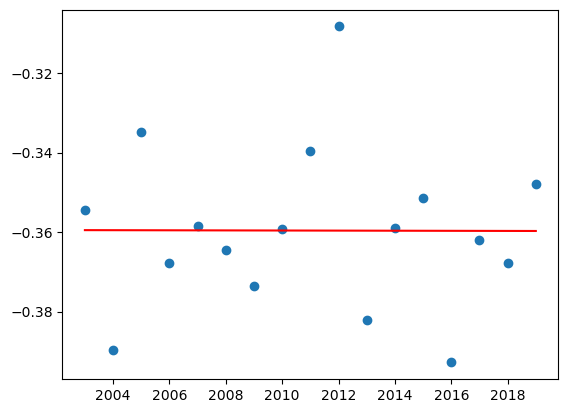

In [14]:
lr_sr_100p = np.polyfit(df100.index, df100["survival_rate"], 1)
display(lr_sr_100p)
# plot scatter and fit
plt.plot(df100.index, df100["survival_rate"], "o")
plt.plot(df100.index, np.polyval(lr_sr_100p, df100.index), color="red")
plt.show()

In [15]:
# Extrapolation to 2100
np.polyval(lr_sr_100p, range(2000,2101))

array([-0.35947316, -0.35948636, -0.35949956, -0.35951276, -0.35952596,
       -0.35953916, -0.35955236, -0.35956556, -0.35957876, -0.35959196,
       -0.35960516, -0.35961836, -0.35963155, -0.35964475, -0.35965795,
       -0.35967115, -0.35968435, -0.35969755, -0.35971075, -0.35972395,
       -0.35973715, -0.35975035, -0.35976355, -0.35977675, -0.35978995,
       -0.35980314, -0.35981634, -0.35982954, -0.35984274, -0.35985594,
       -0.35986914, -0.35988234, -0.35989554, -0.35990874, -0.35992194,
       -0.35993514, -0.35994834, -0.35996153, -0.35997473, -0.35998793,
       -0.36000113, -0.36001433, -0.36002753, -0.36004073, -0.36005393,
       -0.36006713, -0.36008033, -0.36009353, -0.36010673, -0.36011993,
       -0.36013312, -0.36014632, -0.36015952, -0.36017272, -0.36018592,
       -0.36019912, -0.36021232, -0.36022552, -0.36023872, -0.36025192,
       -0.36026512, -0.36027832, -0.36029151, -0.36030471, -0.36031791,
       -0.36033111, -0.36034431, -0.36035751, -0.36037071, -0.36

It looks like the increase of survival rate from 99 to 100 is not changing much with the increase of the years and care technology.

## Projection of the resident population till 2100
I now have all the coefficients to project the population from 2023 till 2100.

In [16]:
dfpproj = dfp.copy()
for y in range(2023, 2101):
    dfpproj.loc[0, y] = dfpproj.loc[18:43, y-1].sum() * birth_propagation_by_year.at[y]
    for age in range(1, 99+1):
        dfpproj.loc[age, y] = dfpproj.loc[age-1, y-1] * (1 + sr_proj.at[age, y])
    dfpproj.loc[100, y] = (dfpproj.loc[99, y-1] + dfpproj.loc[100, y-1]) * (1 + np.polyval(lr_sr_100p, y))
dfpproj

year    2002    2003    2004    2005    2006    2007    2008    2009    2010  \
eta                                                                            
0     523007  535656  542323  558500  551127  556884  560700  570791  562322   
1     529233  526577  538020  545596  559067  552870  560028  563021  569963   
2     528131  533126  531043  540860  548487  560347  556146  562640  564317   
3     518790  530847  537507  535545  543768  550808  563000  559193  564536   
4     515957  522484  534064  542329  540131  545782  554754  565127  560899   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
96     16400   17254   17494   20055   21122   24346   25054   27290   28086   
97     10981   11797   11980   12758   14071   15356   17559   18179   20203   
98      6838    7643    7901    8505    8725    9888   10871   12349   12977   
99      4866    4702    4971    5411    5682    5945    6643    7469    8547   
100     6121    7093    7200    8095    8538    9122    9575   10158   11297   

year    2011  ...           2091           2092           2093           2094  \
eta           ...                                                               
0     553218  ...  160985.707782  158609.773171  156285.205876  154011.330260   
1     561694  ...  163420.110773  160985.707782  158609.773171  156285.205876   
2     569064  ...  165922.371868  163420.110773  160985.707782  158609.773171   
3     565219  ...  168491.060255  165922.371868  163420.110773  160985.707782   
4     565563  ...  171130.395538  168491.060255  165922.371868  163420.110773   
..       ...  ...            ...            ...            ...            ...   
96     29780  ...  213040.166208  214043.949284  218152.070513  220923.178559   
97     21305  ...  184372.801995  184233.085880  185457.967691  189381.119293   
98     14740  ...  161366.867065  157725.144522  157939.413665  159325.491959   
99      9207  ...  131742.658587  134993.335698  132234.587381  132702.395794   
100    13106  ...  226975.126137  229332.766911  232913.425873  233434.053115   

year           2095           2096           2097           2098  \
eta                                                                
0     151792.681188  149622.656834  147501.870694  145431.575822   
1     154011.330260  151792.681188  149622.656834  147501.870694   
2     156285.205876  154011.330260  151792.681188  149622.656834   
3     158609.773171  156285.205876  154011.330260  151792.681188   
4     160985.707782  158609.773171  156285.205876  154011.330260   
..              ...            ...            ...            ...   
96    225050.799372  226322.555749  231557.021618  229577.856950   
97    192155.057737  196120.367661  197605.937659  202562.260770   
98    163038.959923  165775.199431  169551.464020  171193.800944   
99    134157.690783  137582.034435  140193.502021  143696.384984   
100   234061.113590  235387.446833  238419.440276  242022.005667   

year           2099           2100  
eta                                 
0     143414.475595  141449.018955  
1     145431.575822  143414.475595  
2     147501.870694  145431.575822  
3     149622.656834  147501.870694  
4     151792.681188  149622.656834  
..              ...            ...  
96    228988.996263  232480.835614  
97    201213.645805  201079.282456  
98    175854.659252  175048.414745  
99    145400.631631  149680.110123  
100   246558.953785  250543.277462  

[101 rows x 99 columns]

In [17]:
pprojmelt = dfpproj.reset_index().melt(id_vars="eta", var_name="year", value_name="OBS_VALUE")
pprojmelt

eta  year      OBS_VALUE
0       0  2002  523007.000000
1       1  2002  529233.000000
2       2  2002  528131.000000
3       3  2002  518790.000000
4       4  2002  515957.000000
...   ...   ...            ...
9994   96  2100  232480.835614
9995   97  2100  201079.282456
9996   98  2100  175048.414745
9997   99  2100  149680.110123
9998  100  2100  250543.277462

[9999 rows x 3 columns]

In [18]:
fig = px.line(
    pprojmelt, 
    x="eta", 
    y="OBS_VALUE", 
    title=f"Total population in Italy by age group (TOTAL)",
    animation_frame="year",
    markers=False,
)
fig.update_layout(
    xaxis_title="Age",
    yaxis_title="Population",
    # Set limits x axis between 2000 and 2025
    #xaxis_range=["2000-01-01", "2023-01-01"],
)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

Slide the graph to note that, with this constant birth propagation (or fertility rate), the number of newborns drammatically decreases when the hill of 18-43 years old people flattens.

Let's now plot the projected total population:

In [19]:
dfpproj_sum = pd.DataFrame(
    dfpproj.sum(),
    columns=['Population']
).assign(Prediction=lambda x: x.index>=2023).reset_index().rename(columns={'index':'Year'})
dfpproj_sum

year    Population  Prediction
0   2002  5.699327e+07       False
1   2003  5.718638e+07       False
2   2004  5.761199e+07       False
3   2005  5.804437e+07       False
4   2006  5.828900e+07       False
..   ...           ...         ...
94  2096  2.856252e+07        True
95  2097  2.819381e+07        True
96  2098  2.782529e+07        True
97  2099  2.745674e+07        True
98  2100  2.708847e+07        True

[99 rows x 3 columns]

In [20]:
fig = px.line(
    dfpproj_sum,
    x="year",
    y="Population",
    color="Prediction", 
    title="Total population in Italy",
    markers=True,
)
fig.show()

In [21]:
# save projection for next notebook
dfpproj.to_csv("data/3_projection.csv")

## Conclusions
- Under 50 years old I can not clearly see what is the survival rate because it seems like in 2002-2022 there were more changes due to migration inflows/outflows than the actual survival rate due to premature deaths: I assume the survival rate is 0 for this age group.
- I'm Considering a constant fertility rate (i.e., not following further the decreasing trend), equal to the average of the last 20 years 
- The vicious spiral of decreasing newborns/parents will cause a drop in population that is not converging to any asiontotic value
- In 2100 my model predicts the Italian population to halven from 60 Milion to 30 Milion residents

## Follow-up
- Better test the statistical significance of the trends in  survival rate
- Check if there are death tables from ISTAT to better quantify the survival rate, especially under 50 years old
- Some linear trend extrapolation of the survival rate return positive value in the long run: I used a quick and dirty `cummin` method, but it needs to be improved